# INSTALL DL2

In [1]:
!pip install d2l

     |████████████████████████████████| 82 kB 510 kB/s 
     |████████████████████████████████| 20.1 MB 8.8 MB/s 
     |████████████████████████████████| 61 kB 6.8 MB/s 
     |████████████████████████████████| 11.6 MB 25.6 MB/s 
     |████████████████████████████████| 9.9 MB 37.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the p

In [2]:
!pip install matplotlib==3.0.2

     |████████████████████████████████| 12.9 MB 5.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.2 requires matplotlib==3.3.3, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import numpy as np

# CONFIG

In [ ]:
train_model = False

# GET MODEL AND DATA

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# config
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=(5,5), padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=(6,6)), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))



In [ ]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 9, 9])
Sigmoid output shape: 	 torch.Size([1, 16, 9, 9])
AvgPool2d output shape: 	 torch.Size([1, 16, 4, 4])
Flatten output shape: 	 torch.Size([1, 256])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [ ]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
## load mnist dataset
use_cuda = torch.cuda.is_available()

root = './data'
if not os.path.exists(root):
    os.mkdir(root)

In [ ]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 128

train_iter = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_iter = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



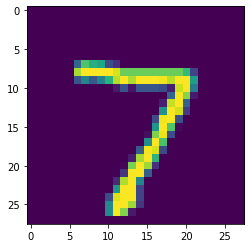

In [ ]:
import matplotlib.pyplot as plt
batch = next(iter(test_iter))
plt.imshow(batch[0][0][0])

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel()) # y.numel() return the number of el in a tensor
        
    return metric[0] / metric[1]

In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)#init weight
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [ ]:
if train_model :
  lr, num_epochs = 0.9, 10
  train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
  torch.save(net, "/content/drive/MyDrive/CS Work/Deep Learning/model_alexnet_newdata.pt")


In [ ]:
# load the model
model2 = torch.load("/content/drive/MyDrive/CS Work/Deep Learning/model_alexnet_newdata.pt")

AttributeError: ignored

In [ ]:
# get a batch
batch = next(iter(test_iter))
# indice 0 -> 7 indice 1 - > 2
model2(batch[0])

tensor([[-1.4879, -0.5589,  3.3838,  ..., 12.8980, -1.3268,  2.0018],
        [ 0.6486,  5.1182, 11.7079,  ..., -2.0710,  1.9049, -6.4429],
        [-5.8808,  9.3060,  2.0478,  ...,  0.5970,  1.5642, -2.1733],
        ...,
        [-3.8072, -3.3312, -1.7265,  ...,  0.4228,  1.2878,  9.7326],
        [ 8.0943, -6.7225,  0.7455,  ..., -1.5845, -0.8225,  2.5540],
        [-2.1854, -3.5831, -8.2574,  ..., -3.5064,  4.3184,  3.3702]],
       grad_fn=<AddmmBackward0>)

# SPLIT OF THE NET (FEATURE EXTRACTOR AND CLASSIFIER)

In [ ]:
for layer in model2:
  print(layer)

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Sigmoid()
AvgPool2d(kernel_size=2, stride=2, padding=0)
Conv2d(6, 16, kernel_size=(6, 6), stride=(1, 1))
Sigmoid()
AvgPool2d(kernel_size=2, stride=2, padding=0)
Flatten(start_dim=1, end_dim=-1)
Linear(in_features=256, out_features=120, bias=True)
Sigmoid()
Linear(in_features=120, out_features=84, bias=True)
Sigmoid()
Linear(in_features=84, out_features=10, bias=True)


In [ ]:
# found feature extractor
for layer in model2[0:6]:
  print(layer)

feature_extractor = model2[0:6]

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Sigmoid()
AvgPool2d(kernel_size=2, stride=2, padding=0)
Conv2d(6, 16, kernel_size=(6, 6), stride=(1, 1))
Sigmoid()
AvgPool2d(kernel_size=2, stride=2, padding=0)


In [ ]:
# found classifier
for layer in model2[6:]:
  print(layer)

classifier = model2[6:]

Flatten(start_dim=1, end_dim=-1)
Linear(in_features=256, out_features=120, bias=True)
Sigmoid()
Linear(in_features=120, out_features=84, bias=True)
Sigmoid()
Linear(in_features=84, out_features=10, bias=True)


# EXTRACT FEATURES

In [ ]:
features = feature_extractor(batch[0])
features.shape


torch.Size([128, 16, 4, 4])

# Utils functions

In [ ]:
def reshape_features(features):
  feat_reshape = features.reshape(
      ( features.shape[0],  features.shape[1],  features.shape[2] * features.shape[3])
      )
  return feat_reshape

#shape_0_feat_reshape = torch.zeros(feat_reshape.shape)

In [ ]:
def reshape_for_classifier(new_features):
  new_features_reshape = new_features.reshape(
                ( new_features.shape[0],  new_features.shape[1],
                int(np.sqrt(new_features.shape[2])), int(np.sqrt(new_features.shape[2])))
                )
  return new_features_reshape

# FOUND THE COMBINAISON OF MODIFICATION

In [ ]:
features.shape

torch.Size([128, 16, 4, 4])

In [ ]:
features_reshape = reshape_features(features)

In [ ]:
# get the number of features to try to make all possibles combinaisons
number_features = features_reshape.shape[1]

In [ ]:
# indice 0 -> 7 indice 1 - > 2
modif_indice = 0 # indice on the batch of the element modify
inserting_indice = 4 # indice in the batch of the element which injected
arg_inserting = int(torch.argmax(classifier(features)[inserting_indice])) # argmax for the inserting_indice 

best_pred = float(classifier(features)[0][2])
best_injection_tuple = (0,0)

# list possible injection and inserting index
list_possible_injection_modif_indice = list(range(number_features))
list_possible_injection_inserting_indice = list(range(number_features))

# list of all modifications

all_tuple_of_injection = []


In [ ]:
# check the prediction before doing the modifications for the modif
torch.argmax(classifier(features)[modif_indice])

tensor(7)

In [ ]:
# check the prediction before doing the modifications for the inserting
torch.argmax(classifier(features)[inserting_indice])

tensor(4)

In [ ]:
def found_best_edit(features_reshape,
                    modif_indice,
                    inserting_indice,
                    arg_inserting,
                    best_pred,
                    best_injection_tuple,
                    list_possible_injection_modif_indice,
                    list_possible_injection_inserting_indice,
                    all_tuple_of_injection):
  """
  function which try each possible combinaison of modif_indic and inserting_indice
  to maximise the prediction of the injection image
  """

  # we want a least on change
  best_pred = float('-inf')

  # counter sur le nombre de modification interessantes
  counter_modif = 0
  # try all combinaison
  print("list possible modif : "+ str(list_possible_injection_modif_indice))
  print("list possible insert : "+ str(list_possible_injection_inserting_indice))
  for i in list_possible_injection_modif_indice:
    for j in list_possible_injection_inserting_indice:
      injection_modif_indice = i # index of the part of the image that will be replaced
      injection_inserting_indice = j  # index of the part of the image that will be injected

      new_features = features_reshape.clone() # copy of the features_reshape
      # add new value
      for k in range(features_reshape.shape[1]):
        # Change is made for each layer
        new_features[modif_indice][k][injection_modif_indice] = features_reshape[inserting_indice][k][injection_inserting_indice]
      # reshape
      new_features_reshape = reshape_for_classifier(new_features)
      # Prediction
      pred = float(classifier(new_features_reshape)[modif_indice][arg_inserting]) # pred with the new feat
      #pred_old = float(classifier(features)[0][2]) # pred old feat

      # tcheck if the pred is interesting
      if pred >= best_pred:
        print("modif trouvée pour la modif : "+str(counter_modif))

        counter_modif = counter_modif + 1
        best_pred = pred
        best_injection_tuple = (injection_modif_indice, injection_inserting_indice)
        #print("nouvelle meilleure pred : "+str(pred))
  
  # check if
  if counter_modif == 0 :
    print("WARNING : NOT ANY INTERESTING MODIFICATION")
  # update features_reshape with the best transformation
  for k in range(features_reshape.shape[1]):
    # for each layer
    features_reshape[modif_indice][k][best_injection_tuple[0]] = features_reshape[inserting_indice][k][best_injection_tuple[1]]
  # remove element selected in lists of possible injections
  print("best injection : "  + str(best_injection_tuple))
  list_possible_injection_modif_indice.remove(best_injection_tuple[0])
  list_possible_injection_inserting_indice.remove(best_injection_tuple[1])

  all_tuple_of_injection.append(best_injection_tuple)

  print("Size of list of possible injections : "+ str(len(list_possible_injection_modif_indice)))


  # return new values
  return features_reshape, best_pred, best_injection_tuple, list_possible_injection_modif_indice, list_possible_injection_inserting_indice, all_tuple_of_injection


### Made edit until the prediction change

In [ ]:
# Doing the modifications until the chnage in the predicitions
pred_has_not_changed = True

counter_nb_modif = 0

while pred_has_not_changed :

  features_reshape, best_pred, best_injection_tuple,\
  list_possible_injection_modif_indice,\
    list_possible_injection_inserting_indice, all_tuple_of_injection = found_best_edit(features_reshape,
                      modif_indice,
                      inserting_indice,
                      arg_inserting,
                      best_pred,
                      best_injection_tuple,
                      list_possible_injection_modif_indice,
                      list_possible_injection_inserting_indice,
                      all_tuple_of_injection)
  # print the nb of modification
  counter_nb_modif = counter_nb_modif + 1
  print("Number of modifications : "+ str(counter_nb_modif))
  # tcheck if the val of prediction has change
  if torch.argmax(classifier(reshape_for_classifier(features_reshape))[modif_indice]) == arg_inserting :
    print("The prediction has changes")
    pred_has_not_changed = False

list possible modif : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
list possible insert : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
modif trouvée pour la modif : 0
modif trouvée pour la modif : 1
modif trouvée pour la modif : 2
modif trouvée pour la modif : 3
modif trouvée pour la modif : 4
best injection : (2, 2)
Size of list of possible injections : 15
Number of modifications : 1
list possible modif : [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
list possible insert : [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
modif trouvée pour la modif : 0
modif trouvée pour la modif : 1
modif trouvée pour la modif : 2
best injection : (4, 6)
Size of list of possible injections : 14
Number of modifications : 2
list possible modif : [0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
list possible insert : [0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15]
modif trouvée pour la modif : 0
modif trouvée pour la modif : 1
best injection : (1, 0)
Size of list of possibl

In [ ]:
# all injection
all_tuple_of_injection

[(2, 2), (4, 6), (1, 0), (3, 5), (6, 10), (7, 11), (5, 9)]

In [ ]:
torch.argmax(classifier(reshape_for_classifier(features_reshape))[modif_indice])

tensor(4)

In [ ]:
# get a batch
batch = next(iter(test_iter))
# indice 0 -> 9 indice 1 - > 2
model2(batch[0])

tensor([[-1.4879, -0.5589,  3.3838,  ..., 12.8980, -1.3268,  2.0018],
        [ 0.6486,  5.1182, 11.7079,  ..., -2.0710,  1.9049, -6.4429],
        [-5.8808,  9.3060,  2.0478,  ...,  0.5970,  1.5642, -2.1733],
        ...,
        [-3.8072, -3.3312, -1.7265,  ...,  0.4228,  1.2878,  9.7326],
        [ 8.0943, -6.7225,  0.7455,  ..., -1.5845, -0.8225,  2.5540],
        [-2.1854, -3.5831, -8.2574,  ..., -3.5064,  4.3184,  3.3702]],
       grad_fn=<AddmmBackward0>)

# Translate the modification in the new coordinates : 

In [ ]:
def index_to_coordinates(index_test, size_shape):
  """
  function that translates the change coordinates in the tensor reshape into the original coordinates
  index_test : val of index in the the reshape tensor
  size_shape : size of the original shape (ex : 4 for a 4*4)
  """
  #index_test = index_test
  # columns indice
  col_indice = (index_test) % size_shape
  # line indice
  line_indice = int((index_test)/ size_shape)

  return (line_indice, col_indice)


In [1]:
def get_original_indexes(indexes, INPUT_1, OUTPUT_SIZE):
    size_ratio = (int(INPUT_1[0]/OUTPUT_SIZE[0]), int(INPUT_1[1]/OUTPUT_SIZE[1]))
    original_indexes = []
    #print(size_ratio)

    for index in indexes:
        for i in range(size_ratio[0]):
            for j in range(size_ratio[1]):
                new_index = [index[0]*size_ratio[0], index[1]*size_ratio[1]]
                if new_index[0] + i < INPUT_1[0]:
                    new_index[0] += i
                if new_index[1] + j < INPUT_1[1]:
                    new_index[1] += j
                original_indexes.append(new_index)
    return original_indexes

In [6]:
get_original_indexes([(0,0)], (28,28), (4,4))

[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [1, 0],
 [1, 1],
 [1, 2],
 [1, 3],
 [1, 4],
 [1, 5],
 [1, 6],
 [2, 0],
 [2, 1],
 [2, 2],
 [2, 3],
 [2, 4],
 [2, 5],
 [2, 6],
 [3, 0],
 [3, 1],
 [3, 2],
 [3, 3],
 [3, 4],
 [3, 5],
 [3, 6],
 [4, 0],
 [4, 1],
 [4, 2],
 [4, 3],
 [4, 4],
 [4, 5],
 [4, 6],
 [5, 0],
 [5, 1],
 [5, 2],
 [5, 3],
 [5, 4],
 [5, 5],
 [5, 6],
 [6, 0],
 [6, 1],
 [6, 2],
 [6, 3],
 [6, 4],
 [6, 5],
 [6, 6]]

In [ ]:
import matplotlib.pyplot as plt
def visualize_transformation(original_indexes, original_image):
    original_image = original_image.tolist()
    highlighted_image = original_image.copy()

    for i,j in original_indexes:
      try:
          highlighted_image[i][j] = max((highlighted_image[i][j]+0.4),1)
      except :
        print("impossible : "+str(i)+str(j))

    plt.imshow(highlighted_image)
    plt.show()
    
    return highlighted_image


In [ ]:
all_tuple_of_injection

[(2, 2), (4, 6), (1, 0), (3, 5), (6, 10), (7, 11), (5, 9)]

In [ ]:
injection_first_image = [x[0] for x in all_tuple_of_injection]
injection_second_image = [x[1] for x in all_tuple_of_injection]
injection_first_image
injection_second_image

[2, 6, 0, 5, 10, 11, 9]

In [ ]:
# conversion des coordonnées de shape (16,) à (4,4) (par exemple)
size_shape = 4
coordinates_injection_first_image =  [index_to_coordinates(x, size_shape) for x in injection_first_image]
coordinates_injection_second_image =  [index_to_coordinates(x, size_shape) for x in injection_second_image]

coordinates_injection_first_image
coordinates_injection_second_image

[(0, 2), (1, 2), (0, 0), (1, 1), (2, 2), (2, 3), (2, 1)]

In [ ]:
# original indexes
INPUT_1 = (28,28)
OUTPUT_SIZE = (4,4)

In [ ]:
# get the original coordinates
index_original_coordinates_first_image = get_original_indexes(coordinates_injection_first_image, INPUT_1, OUTPUT_SIZE)
index_original_coordinates_second_image = get_original_indexes(coordinates_injection_second_image, INPUT_1, OUTPUT_SIZE)

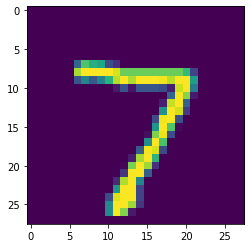

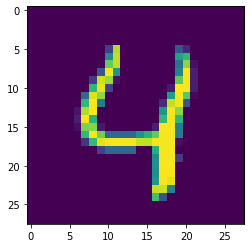

In [ ]:
# get the original images
original_first_image = batch[0][modif_indice][0]
original_second_image = batch[0][inserting_indice][0]

# plot
plt.figure()
plt.imshow(original_first_image)
plt.figure()
plt.imshow(original_second_image)

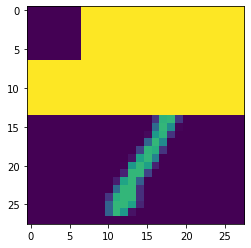

In [ ]:
img = visualize_transformation(index_original_coordinates_first_image, original_first_image)

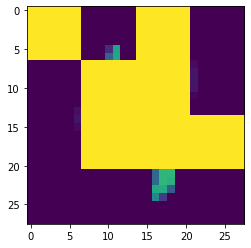

In [ ]:
img2 = visualize_transformation(index_original_coordinates_second_image, original_second_image)

# Combining images

In [ ]:
def combine_images(original_first_image, original_second_image, INPUT_1, OUTPUT_SIZE):
  """
  function thet matches by injecting the parts of the image 2 in the image 1
  params:
    original_first_image: the first image (modif image)
    original_second_image: the second image (injecting image)
    INPUT_1: size of the input image in the net (ex : (28,28))
    OUTPUT_SIZE : size of the output at the end of the feature extractor (ex: (4,4))

  """
  #original_second_image used also
  original_image_test = original_first_image.tolist()
  printed_image = original_image_test.copy()

  for k in range(len(coordinates_injection_first_image)):
    first_image = get_original_indexes(coordinates_injection_first_image[k:k+1], INPUT_1, OUTPUT_SIZE)
    second_image = get_original_indexes(coordinates_injection_second_image[k:k+1], INPUT_1, OUTPUT_SIZE)

    # les indexes are sorted by columns and by line before doing the matching
    first_image = sorted(first_image, key=lambda x: x[1])
    first_image = sorted(first_image, key=lambda x: x[0])

    # les indexes are sorted by columns and by line before doing the matching
    second_image = sorted(second_image, key=lambda x: x[1])
    second_image = sorted(second_image, key=lambda x: x[0])

    # replace elements
    if len(first_image) != len(second_image):
      print("Error of size in the matching of pixels for the index of transformation: "+str(k))

    for i in range(len(first_image)):
        printed_image[ first_image[i][0]][ first_image[i][1]] = original_second_image[second_image[i][0]][second_image[i][1]]

  plt.imshow(printed_image)
  plt.show()


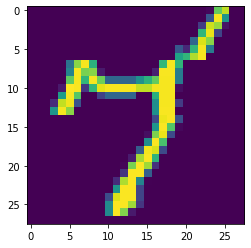

In [ ]:
combine_images(original_first_image, original_second_image, INPUT_1, OUTPUT_SIZE)